In [23]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install numpy
!pip install stable-baselines3[extra_requirements]

  Using cached setuptools-64.0.2-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.0.3
    Uninstalling setuptools-69.0.3:
      Successfully uninstalled setuptools-69.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cvxpy 1.3.3 requires setuptools>65.5.1, but you have setuptools 64.0.2 which is incompatible.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-bkqdri0k
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-bkqdri0k
  Resolved https://github.com/AI4Finance-LLC/FinRL-Library.git to commit 3393f62e65248a15f1ff5a289c2ed82860fc30fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-huf28msv/elegantrl_dd84c7f774f24b8c9f32ade69d2761a7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-huf28msv/elegantrl_dd84c7f774f24b8c9f32ade69d

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [26]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [27]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [28]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (96942, 8)


In [29]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.290511,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,35.014778,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.563838,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850750,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.333208,15308300,CAT,2


In [30]:
df.tail()

,date,open,high,low,close,volume,tic,day
96937,2022-05-31,503.619995,504.109985,495.660004,484.653229,4003100,UNH,1
96938,2022-05-31,210.380005,214.350006,209.110001,209.657623,9586400,V,1
96939,2022-05-31,51.259998,51.560001,50.849998,45.635311,25016600,VZ,1
96940,2022-05-31,43.480000,44.270000,43.049999,39.938351,8192000,WBA,1
96941,2022-05-31,127.459999,129.899994,127.419998,125.674347,12304100,WMT,1


In [31]:
df.shape

(96942, 8)

In [32]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.290511,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,35.014778,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.563838,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850750,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.333208,15308300,CAT,2


In [33]:
len(df.tic.unique())

30

In [34]:
df.tic.value_counts()

tic
AAPL    3315
AMGN    3315
WMT     3315
WBA     3315
VZ      3315
V       3315
UNH     3315
TRV     3315
PG      3315
NKE     3315
MSFT    3315
MRK     3315
MMM     3315
MCD     3315
KO      3315
JPM     3315
JNJ     3315
INTC    3315
IBM     3315
HON     3315
HD      3315
GS      3315
DIS     3315
CVX     3315
CSCO    3315
CRM     3315
CAT     3315
BA      3315
AXP     3315
DOW      807
Name: count, dtype: int64

In [35]:
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [36]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [37]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
79772,2020-03-05,121.300003,122.900002,120.279999,110.143143,9363500,PG,3,-1.203153,48.486226,-54.244356,8.828895,67.571011
17947,2011-09-13,21.915001,21.977501,21.665001,20.097994,17469600,V,1,0.202195,54.123950,86.095249,2.919377,20.862782
11372,2010-10-20,78.900002,80.779999,78.809998,56.433090,9662300,CAT,2,1.235627,61.936049,66.193931,7.269431,24.932753
27835,2013-01-23,56.110001,56.250000,55.450001,47.231064,6665700,UNH,2,0.254791,55.922517,143.484546,37.233908,66.265760
81510,2020-06-01,182.539993,183.000000,181.460007,177.155151,22622400,MSFT,0,2.683482,55.183476,44.741316,14.891719,32.824689


In [38]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [39]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [40]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [41]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1,
                 'ddpg' : 1
                 }

In [42]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  203.4044227075561
======Model training from:  2009-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
======A2C Validation from:  2021-01-04 to  2021-04-06
A2C Sharpe Ratio:  0.2943637940711721
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_1
------------------------------------
| time/              |             |
|    fps             | 35          |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2           |
| train/             |             |
|    reward          | 0.018587552 |
------------------------------------
======PPO Validation from:  2021-01-04 to  2021-04-06
PPO Sharpe Ratio:  0.3305848489079733
======DDPG Training========
{'buf

In [43]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,PPO,0.294364,0.330585,0.280899
1,189,2021-04-06,2021-07-06,DDPG,0.194376,0.189344,0.303698
2,252,2021-07-06,2021-10-04,DDPG,-0.150698,-0.220353,-0.01178
3,315,2021-10-04,2022-01-03,DDPG,0.019315,0.13234,0.224136


In [44]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [45]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.13472554483354027


In [46]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2021-04-06,NaN,2021-04-06
1,999657.415122,2021-04-07,-0.000343,2021-04-07
2,998744.195569,2021-04-08,-0.000914,2021-04-08
3,999708.967286,2021-04-09,0.000966,2021-04-09
4,999350.824406,2021-04-12,-0.000358,2021-04-12


<Axes: >

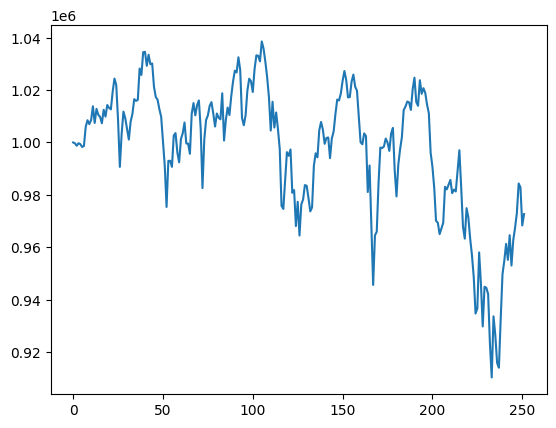

In [47]:
%matplotlib inline
df_account_value.account_value.plot()

In [48]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.027358
Cumulative returns    -0.027358
Annual volatility      0.137127
Sharpe ratio          -0.134726
Calmar ratio          -0.221374
Stability              0.361997
Max drawdown          -0.123581
Omega ratio            0.977770
Sortino ratio         -0.185816
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.850118
Daily value at risk   -0.017350
dtype: float64


In [49]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


In [50]:
!pip install alpaca-py
!pip install alpaca

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 10.4
    Uninstalling websockets-10.4:
      Successfully uninstalled websockets-10.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alpaca-trade-api 3.2.0 requires websockets<11,>=9.0, but you have websockets 11.0.3 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for alpaca: filename=alpaca-1.0.0-py3-none-any.whl size=14064 sha256=a8bb6b52b0bcab9cc3f55cf8cc4b13acb6a582e82c87f7ec62ae0df825c3db5d
  Stored in directory: /root/.cache/pip/wheels/4a/26/e0/b1ae89a6dc93defaa52a502f261a1680d96d9a7a9539baca48
Successfully built alpaca


In [51]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest
# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('PKTNUV3XHHRPNYPU51QC', 'IX98OiSPyY2g7SxocNex4G6Q2chwgiGterZta4ym', paper=True)


##Market Order
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )

# if(DRLEnsembleAGent.Sharpe > .4)

# # Market order
# market_order = trading_client.submit_order(fndsdsdsfdsdsf
#                 order_data=market_order_data
#                )

# else

# print(no trades for today)



In [52]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest

# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('PKTNUV3XHHRPNYPU51QC', 'IX98OiSPyY2g7SxocNex4G6Q2chwgiGterZta4ym', paper=True)


##Market Order
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="SPY",
                    qty=10,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )


## Twitter Sentiment Analysis

# limit_order_data = LimitOrderRequest(
#                     symbol="BTC/USD",
#                     limit_price=17000,
#                     notional=4000,
#                     side=OrderSide.SELL,
#                     time_in_force=TimeInForce.FOK
#                    )

# # Limit order
# limit_order = trading_client.submit_order(
#                 order_data=limit_order_data
#               )

# wss_client = StockDataStream('AKIQ3ALAC0B2HOM1PPNE', 'dMekSYsqKqyoF6WM4lJ8YnE92ERDxeQVrhvrjAxa')

# # async handler
# async def quote_data_handler(data):
#     # quote data will arrive here
#     print(data)


# wss_client.subscribe_quotes(quote_data_handler, "AAPL")

# wss_client.run()

# # no keys required for crypto data
# client = CryptoHistoricalDataClient()

# request_params = CryptoBarsRequest(
#                         symbol_or_symbols=["BTC/USD", "ETH/USD"],
#                         timeframe=TimeFrame.Day,
#                         start=datetime.datetime(2022, 12, 20, 14, 30)
#                  )

# bars = client.get_crypto_bars(request_params)
# bars.df
# print(bars)